## Kosten van uniforme doorsnede-eisen
Een belangrijke vraag bij het ontwerp is de verdeling van doorsnede-eisen over de mechanismen.
In dit notebook kijken we naar de kosten van verschillende ontwerpeisen, waarbij we de ontwerpeisen uniform houden per dijkvak. 
Dat geeft inzicht in:
* Wat optimale (uniforme/top-down) eisen zijn voor het traject
* Wat de eventuele meerwaarde is van het varieren van eisen over mechanismen en vakken (conform veiligheidsrendement)

We kijken hiervoor naar traject 10-1, op basis van LBO-1, maar zonder lengte-effect.

In [5]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
import itertools

from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.database_analytics import *
from postprocessing.database_access_functions import * 

from postprocessing.generate_output import *
import matplotlib.pyplot as plt

from common_functions.Deltares_colors import Deltares_colors 

sns.set(style="whitegrid")
colors =  Deltares_colors().sns_palette("DeltaresFull")

In [6]:
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_LBO1_metbodemdaling\database_10-1.sqlite")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling\database_10-1.sqlite")    
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling\lengte-effecten\database_10-1.sqlite")

# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\38-1_basis.db")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\sensitivity\38-1_basis_0_modified_beta_15.db")
db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\lengte_effecten\38-1_basis.db")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\53-1\53-1_vakindeling1.db")
# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten\10-1\database_10-1_LBO1.sqlite")
# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\10-2\database_10-2.sqlite")
# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten\24-3\24-3_database.db")
has_revetment = False
LE = 4 # ['no', 4, 'full'] 
# LE = 'full'

_runs_overview = get_overview_of_runs(db_path)
_runs_overview

[{'id': 1,
  'name': 'Basisberekening Veiligheidsrendement',
  'discount_rate': 0.016,
  'optimization_type': 1,
  'optimization_type_name': 'VEILIGHEIDSRENDEMENT'},
 {'id': 2,
  'name': 'Basisberekening Doorsnede-eisen',
  'discount_rate': 0.016,
  'optimization_type': 2,
  'optimization_type_name': 'DOORSNEDE-EISEN'}]

In [ ]:
#VRM results
optimization_steps = get_optimization_steps_for_run_id(db_path, 1)
considered_tc_step = get_minimal_tc_step(optimization_steps)-1

lists_of_measures = get_measures_for_run_id(db_path, 1)
measures_per_step = get_measures_per_step_number(lists_of_measures)

assessment_results = {}
for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER, MechanismEnum.REVETMENT]:
    if has_revetment or mechanism != MechanismEnum.REVETMENT:
        assessment_results[mechanism] = import_original_assessment(db_path, mechanism)


reliability_per_step = get_reliability_for_each_step(db_path, measures_per_step)

stepwise_assessment = assessment_for_each_step(copy.deepcopy(assessment_results), reliability_per_step)

traject_probability = calculate_traject_probability_for_steps(stepwise_assessment)

def calculate_traject_probability(traject_prob):
    p_nonf = [1] * len(list(traject_prob.values())[0].values())
    for mechanism, data in traject_prob.items():
        time, pf = zip(*sorted(data.items()))
        
        p_nonf = np.multiply(p_nonf, np.subtract(1,pf))
    return time, list(1-p_nonf)

traject_probs = [calculate_traject_probability(traject_probability_step ) for traject_probability_step in traject_probability]

ValueError: min() arg is an empty sequence

Now we are going to read the measures for each section, and for a grid of probabilities determine the costs associated with meeting a set of requirements for overflow, stability & piping. This grid runs from the standard to 100000 more stringent for each.

In [ ]:
import pandas as pd

# Define the function to get measures for all sections
def get_measures_for_all_sections(db_path, t_design):
    # Fetch all MeasureResultMechanism records for the specified year
    measures_for_all_sections_beta = (MeasureResultMechanism
                                      .select(MeasureResultMechanism, MechanismPerSection, Mechanism.name)
                                      .join(MechanismPerSection, on=(MechanismPerSection.id == MeasureResultMechanism.mechanism_per_section_id))
                                      .join(Mechanism, on=(Mechanism.id == MechanismPerSection.mechanism_id))
                                      .where(MeasureResultMechanism.time == t_design))

    # Fetch all MeasureResultSection records for the specified year
    measures_for_all_sections_cost = (MeasureResultSection
                                      .select()
                                      .where(MeasureResultSection.time == t_design))
    
    measure_types_for_all_sections = (MeasureResult
                                      .select(MeasureResult, MeasurePerSection, Measure, MeasureType)
                                        .join(MeasurePerSection, on=(MeasurePerSection.id == MeasureResult.measure_per_section_id))
                                        .join(Measure, on=(Measure.id == MeasurePerSection.measure_id))
                                        .join(MeasureType, on=(MeasureType.id == Measure.measure_type_id)))

    # Convert the beta query results to a list of dictionaries
    beta_data_list = []
    for measure in measures_for_all_sections_beta:
        data = measure.__data__
        data['mechanism_name'] = measure.mechanism_per_section.mechanism.name
        data['section_id'] = measure.mechanism_per_section.section_id
        beta_data_list.append(data)
    
    measure_type_data_list = []
    for measure in measure_types_for_all_sections:
        data = measure.__data__
        data['measure_type_id'] = measure.measure_per_section.measure.measure_type.id
        measure_type_data_list.append(data)

    # Convert to Pandas DataFrame
    beta_df = pd.DataFrame(beta_data_list)
    beta_df.drop(columns=['id', 'mechanism_per_section'], inplace=True)
    beta_df = beta_df.pivot(index=['section_id','measure_result'], columns=['mechanism_name'], values='beta')
    #remove mechanism_name from the index
    beta_df.reset_index(inplace=True)
    beta_df.set_index('measure_result', inplace=True)
    
    # Convert the cost query results to a list of dictionaries
    cost_data_list = []
    for measure in measures_for_all_sections_cost:
        cost_data_list.append({'measure_result_id': measure.measure_result_id, 'cost': measure.cost})
    # Convert to Pandas DataFrame
    cost_df = pd.DataFrame(cost_data_list)
    cost_df.set_index('measure_result_id', inplace=True)
    
    #measure type list
    measure_type_data = pd.DataFrame(measure_type_data_list)[['id', 'measure_type_id']].rename(columns={'id':'measure_result'})
    measure_type_data.drop_duplicates(inplace=True)
    df = beta_df.join(measure_type_data.set_index('measure_result'))
    # Join the beta and cost DataFrames
    df = df.join(cost_df)
    
    return df

t_design = 50
measures_df_db = get_measures_for_all_sections(db_path, t_design)

In [ ]:
#now we want to add grond+vzg for all sections as otherwise the comparison is unfair

def add_combined_vzg_soil(df):
    #copy original dataframe
    df_out = df.copy()
    for section in df.section_id.unique():
        #we get all soil reinforcements (all measures with measure_type_id 1) and make a new df of it. Make sur it is a copy
        soil = df[(df.section_id == section) & (df.measure_type_id == 1)].copy()
        vzg = df[(df.section_id == section) & (df.measure_type_id == 3)].copy()
        soil.loc[:,'cost'] = np.add(soil.cost, vzg['cost'].values[0])

        beta_piping = soil.Piping
        new_beta_piping = pf_to_beta(beta_to_pf(beta_piping)/1000.)
        soil.loc[:,'Piping'] = new_beta_piping
        soil.loc[:,'measure_type_id'] = 99
        df_out = pd.concat([df_out, soil])
    return df_out

measures_df = add_combined_vzg_soil(measures_df_db)
#sort measures_df by section_id and measure_result
measures_df.sort_values(by=['section_id', 'measure_result'], inplace=True)

#as probabilities in the df are to be interpreted as probabilities per section, we need to also compute the corresponding cross section probabilities

#get the section lengths from the database
section_lengths = pd.DataFrame([(section.id, section.section_length) for section in SectionData.select()],columns= ['section_id', 'section_length'])
section_lengths.set_index('section_id', inplace=True)
#merge lengths to measures_df
measures_df_with_dsn = measures_df.merge(section_lengths, left_on='section_id', right_index=True)
measures_df_with_dsn['Overflow_dsn'] = measures_df_with_dsn['Overflow']
if LE == 'full':
    N_piping = measures_df_with_dsn['section_length'] / 300
    N_piping = N_piping.apply(lambda x: max(x, 1))
    measures_df_with_dsn['Piping_dsn'] = pf_to_beta(beta_to_pf(measures_df_with_dsn['Piping']) / N_piping)
    N_stability = measures_df_with_dsn['section_length'] / 50
    N_stability = N_stability.apply(lambda x: max(x, 1))
    measures_df_with_dsn['StabilityInner_dsn'] = pf_to_beta(beta_to_pf(measures_df_with_dsn['StabilityInner']) / N_stability)
elif LE == 'no':
    measures_df_with_dsn['Piping_dsn'] = measures_df_with_dsn['Piping']
    measures_df_with_dsn['StabilityInner_dsn'] = measures_df_with_dsn['StabilityInner']
else: #numerical value for LE with which we upscale
    N_piping = measures_df_with_dsn['section_length'] / 300
    N_piping = N_piping.apply(lambda x: max(x, 1)) #minimum 1
    N_piping = N_piping.apply(lambda x: min(x, LE)) #maximum LE
    measures_df_with_dsn['Piping_dsn'] = pf_to_beta(beta_to_pf(measures_df_with_dsn['Piping']) / N_piping)
    N_stability = measures_df_with_dsn['section_length'] / 50
    N_stability = N_stability.apply(lambda x: max(x, 1))
    N_stability = N_stability.apply(lambda x: min(x, LE)) #maximum LE
    measures_df_with_dsn['StabilityInner_dsn'] = pf_to_beta(beta_to_pf(measures_df_with_dsn['StabilityInner']) / N_stability)
measures_df_with_dsn.head()


,section_id,Overflow,Piping,StabilityInner,measure_type_id,cost,section_length,Overflow_dsn,Piping_dsn,StabilityInner_dsn
measure_result,,,,,,,,,,
1,1,3.490467,2.301524,2.742803,1,9.062596e+04,359.0,3.490467,2.368688,3.170278
1,1,3.490467,4.250157,2.742803,99,1.957426e+06,359.0,3.490467,4.290199,3.170278
2,1,3.490467,2.418563,3.416123,1,1.694887e+06,359.0,3.490467,2.483191,3.776890
2,1,3.490467,4.320297,3.416123,99,3.561687e+06,359.0,3.490467,4.359750,3.776890
3,1,3.490467,2.486147,3.818035,1,2.257444e+06,359.0,3.490467,2.549389,4.147383


In [ ]:
#get the Pmax from DikeTrajectInfo
p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
omega_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_piping
omega_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_stability_inner
omega_overflow = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_overflow
a_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).a_piping
a_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).a_stability_inner
b_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).b_stability_inner
b_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).b_piping
traject_length = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_length

#make a N based grid
# N_omega = [2., 3., 4., 5., 7., 10., 15., 25., 50.]
# N_LE = [5., 10., 20., 30., 40., 50.]

#smaller grid
N_omega = [2., 4., 8., 16., 32.]
N_LE = [5., 10., 20., 40., 50.]

N_overflow_grid = N_omega.copy()
N_piping_grid = sorted(set([a*b for a,b in list(itertools.product(N_omega, N_LE))]))
N_stability_inner_grid = sorted(set([a*b for a,b in list(itertools.product(N_omega, N_LE))]))

#add existing values:
N_overflow_grid = N_overflow_grid + [np.divide(1, omega_overflow)]
N_piping_grid = N_piping_grid + [np.divide(1,omega_piping) * np.divide(a_piping * traject_length, b_piping )]
N_stability_inner_grid = N_stability_inner_grid + [np.divide(1,omega_stability_inner) * np.divide(a_stability_inner * traject_length, b_stability_inner)]

#make a beta_grid for all
overflow_grid = pf_to_beta(np.divide(p_max, N_overflow_grid))
piping_grid = pf_to_beta(np.divide(p_max, N_piping_grid))
stability_inner_grid = pf_to_beta(np.divide(p_max, N_stability_inner_grid))
                                  
# #make a grid for all 3 mechanisms. 
target_beta_grid_all = itertools.product(overflow_grid, piping_grid, stability_inner_grid)
print(f"Grid dimensions are {len(overflow_grid)} x {len(piping_grid)} x {len(stability_inner_grid)}")

Grid dimensions are 6 x 14 x 14


In [ ]:
#now we want to make a grid where N_omega is a combination for each mechanism stored in a tuple. And then combine with all N_LE values.
#These are tuples for N_omega for overflow, piping and stability inner
N_omega_tuples = [(1./.24, 1/.24, 1/.04), 
                  (1/.1, 1/.24, 1/.18), 
                  (1/.24, 1/.04, 1/.24)]
#now we combine with all N_LE values. For overflow this is not necessary but for piping and stability inner it is. We also need permutations for the N_LE values
# N_LE_permutations = list(itertools.permutations(N_LE, 2))
#actually there are way less combinations. We can just combine the values from 2 lists:
N_LE_permutations = [(0.4*traject_length/b_piping, 0.033*traject_length/b_stability_inner),(0.9*traject_length/b_piping, 0.033*traject_length/b_stability_inner)]
#Overflow grid doesnt depend on N_LE but we need it to have the same length so we grab the first from N_omega_tuples and give it the same length as N_LE_permutations and then append for each value
N_overflow_grid_specific = [[N_omega_tuple[0]] * len(N_LE_permutations) for N_omega_tuple in N_omega_tuples]
#flatten the list
N_overflow_grid_specific = [item for sublist in N_overflow_grid_specific for item in sublist]

#now we get a grid for piping where we combine the second value of the N_omega_tuples with all N_LE values
N_piping_grid_specific = [N_omega_tuple[1] * N_LE_permutation[0]for N_omega_tuple in N_omega_tuples for N_LE_permutation in N_LE_permutations]
#now we get a grid for stability inner where we combine the third value of the N_omega_tuples with all N_LE values
N_stability_inner_grid_specific = [N_omega_tuple[2] * N_LE_permutation[1]for N_omega_tuple in N_omega_tuples for N_LE_permutation in N_LE_permutations]
#make a beta_grid for all

overflow_grid_specific = pf_to_beta(np.divide(p_max, N_overflow_grid_specific))
piping_grid_specific = pf_to_beta(np.divide(p_max, N_piping_grid_specific))
stability_inner_grid_specific = pf_to_beta(np.divide(p_max, N_stability_inner_grid_specific))

#zip the 3 grids
target_beta_grid_specific = list(zip(overflow_grid_specific, piping_grid_specific, stability_inner_grid_specific))

In [ ]:
def compute_traject_probability(minimal_cost_dataset):
    #no upscaling in sections. 
    pf_overflow = max(beta_to_pf(minimal_cost_dataset['Overflow']))
    p_nonf_piping = np.product(np.subtract(1,beta_to_pf(minimal_cost_dataset['Piping'])))
    p_nonf_stability = np.product(np.subtract(1,beta_to_pf(minimal_cost_dataset['StabilityInner'])))
    pf_traject = 1- (1-pf_overflow)*(p_nonf_piping)*(p_nonf_stability)
    return pf_traject

def calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df):
    #calculate the cost for the given beta values

    #get all sections
    sections = measures_df['section_id'].unique()


    possible_measures = measures_df.loc[(measures_df['Overflow_dsn'] >= overflow_beta) & 
                    (measures_df['Piping_dsn'] >= piping_beta) & 
                        (measures_df['StabilityInner_dsn'] >= stability_beta)]
    #get the minimal cost for each section_id and the betas that belong to that measure
    minimal_costs_idx = possible_measures.reset_index().groupby('section_id')['cost'].idxmin()
    minimal_costs_data = possible_measures.reset_index().loc[minimal_costs_idx]

    computed_traject_probability = compute_traject_probability(minimal_costs_data)

    minimal_costs = minimal_costs_data['cost']
    #check if all sections are in the minimal_costs, if any of them is not in there return 1e99, else return the sum of the costs
    if len(sections) != len(minimal_costs):
        return 1e99, computed_traject_probability, minimal_costs_data
    else:
        return minimal_costs.sum(), computed_traject_probability, minimal_costs_data


cost = []
pf_traject = []
for count, (overflow_beta, piping_beta, stability_beta) in enumerate(list(copy.deepcopy(target_beta_grid_all))):
    cost_i, pf_traject_i, get_measures_per_section_for_step = calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df_with_dsn)
    if cost_i < 1.e99:
        cost.append(cost_i)
        pf_traject.append(pf_traject_i)
    else:
        pass
        # print(f"Skipping beta combination {overflow_beta, piping_beta, stability_beta}")

cost_specific = []
pf_traject_specific = []
for count, (overflow_beta, piping_beta, stability_beta) in enumerate(copy.deepcopy(target_beta_grid_specific)):
    cost_i, pf_traject_i, measures_i = calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df_with_dsn)
    if cost_i < 1.e99:
        cost_specific.append(cost_i)
        pf_traject_specific.append(pf_traject_i)
    else:
        pass
        # print(f"Skipping beta combination {overflow_beta, piping_beta, stability_beta}")


In [ ]:
#find the indices in the optimization steps where the total_risk is the same as the step before
risk_decrease = np.abs(np.diff([optimization_steps[i]['total_risk'] for i in range(len(traject_probs))]))
cost_increase = np.diff([optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))])

#VRM
#find index where traject_probs[0][0] == 50
ind_2075 = np.where(np.array(traject_probs[0][0]) ==50)[0][0]
pf_2075 = [traject_probs[i][1][ind_2075] for i in range(len(traject_probs))]
cost_vrm = [optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))]

#get indices of measures with a BC lower than 0.8 (1 and some tolerance)
BC_ratio = risk_decrease/cost_increase
low_bc_idx = np.where(BC_ratio < 1.0)[0] + 1

#remove the elements in idx_out as they are not effective
pf_2075_filtered = np.delete(pf_2075, low_bc_idx)
cost_vrm_filtered = np.delete(cost_vrm, low_bc_idx)

#compare original and new length
print(f'Original length: {len(pf_2075)} and new length: {len(pf_2075_filtered)}')

#DSN-eisen eindpunt:
if db_path.parent == Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling'):
    pf_dsn = 3.55e-4
    cost_dsn = 81.86e6
elif db_path.parent == Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1'):
    pf_dsn = 0.000016
    cost_dsn = 3.424034e+08
elif db_path.parent == Path(r'c:/Users/klerk_wj/OneDrive - Stichting Deltares/00_Projecten/11_VR_HWBP/05_Handreiking/casus_ontwerpen/10-1/versie 2/10-1_Trajectaanpak_metbodemdaling/lengte-effecten'):
    pf_dsn = 5.49e-4
    cost_dsn = 84.49e6
    #remove a few values from the path for pf_2075_filtered and cost_vrm_filtered with index 85, 86
    pf_2075_filtered = np.delete(pf_2075_filtered, [ 184, 186, 187, 188])
    cost_vrm_filtered = np.delete(cost_vrm_filtered, [ 184, 186, 187, 188])
else:#point out of graph
    print('Doorsnede-eisen niet gegeven')
    pf_dsn = p_max
    cost_dsn = -5


Original length: 330 and new length: 209
Doorsnede-eisen niet gegeven


C:\Users\klerk_wj\AppData\Local\Temp\ipykernel_44864\927022402.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x/1e6:.0f}' for x in ax.get_xticks()]);


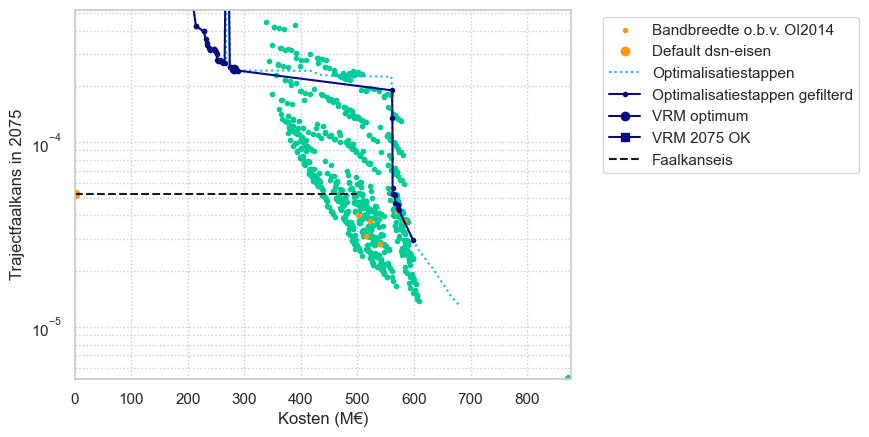

In [ ]:
fig,ax = plt.subplots()
ax.scatter(cost, pf_traject, color = colors[4], marker = '.')
ax.scatter(cost_specific, pf_traject_specific, color = colors[6], marker = '.', label = 'Bandbreedte o.b.v. OI2014')
# ax.plot(85858728.5666441, 5e-4, 'go')
#10-1 trajectaanpak
# ax.plot(62e6, 0.0002984669659441552, 'go', label='VRM optimaal')
ax.plot(cost_dsn, pf_dsn, color = colors[6], marker = 'o', linestyle = '', label= 'Default dsn-eisen')
ax.plot(cost_vrm, pf_2075, color=colors[2], linestyle = ':', label = 'Optimalisatiestappen')
ax.plot(cost_vrm_filtered, pf_2075_filtered, color=colors[0], label = 'Optimalisatiestappen gefilterd', marker = '.')
ax.plot(optimization_steps[considered_tc_step-1]['total_lcc'], traject_probs[considered_tc_step-1][1][ind_2075], marker = 'o',color = colors[0], label='VRM optimum')
ax.plot(optimization_steps[min(np.where(pf_2075_filtered<p_max)[0])]['total_lcc']+1, traject_probs[min(np.where(pf_2075_filtered<p_max)[0])][1][ind_2075]+1, marker = 's',color = colors[0], label='VRM 2075 OK')
ax.set_xlim(left = 0, right = max(cost))
ax.hlines(p_max, 0, 5e8, colors='k', linestyles='dashed', label='Faalkanseis')
ax.set_ylim(top=p_max *10,  bottom = p_max/10)
ax.set_xlabel('Kosten (M€)')
ax.set_ylabel('Trajectfaalkans in 2075')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1))
#get xtick labels and divide by 1e6 and replace
ax.set_xticklabels([f'{x/1e6:.0f}' for x in ax.get_xticks()]);
ax.grid(True, which='both', linestyle=':')

#save the figure
save_dir = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\vergelijkingen_uniforme_kansen')

if LE== 'full':
    plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_LE.png'), dpi=300, bbox_inches='tight')
elif LE == 'no':
    plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}.png'), dpi=300, bbox_inches='tight')
else:
    plt.savefig(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_{db_path.stem}.png'), dpi=300, bbox_inches='tight')


#add veiligheidsrendement

In [ ]:
db_path.stem

'38-1_basis_0_modified_beta_15'

In [ ]:
dataset = pd.DataFrame([N_overflow_grid_specific, N_piping_grid_specific, N_stability_inner_grid_specific, pf_traject_specific, cost_specific],index=['N_overslag', 'N_piping', 'N_stability', 'Pf_traject', 'cost']).T
vrm_cost = cost_vrm[np.where(np.array(pf_2075)<p_max)[0][0]]
min_dsn_cost = min(np.array(cost)[np.where(np.array(pf_traject)<p_max)[0]])
dataset['unsafe OI'] = dataset['Pf_traject'] > p_max
dataset['% cost diff VRM'] = np.divide(dataset['cost'] - vrm_cost, vrm_cost) * 100
dataset['% cost diff optimal uniform'] = np.divide(dataset['cost'] - min_dsn_cost, min_dsn_cost) * 100
if LE:
    dataset.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_LE_factsheet.csv'))
else:
    dataset.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_noLE_factsheet.csv'))


In [ ]:
#find the index where cost is minimal and pf_traject is below p_max
min_idx = np.where(np.array(pf_traject)<p_max)[0][np.argmin(np.array(cost)[np.where(np.array(pf_traject)<p_max)])]
min_idx

426

[8.000000000000007, 40.0, 200.00000000000094]


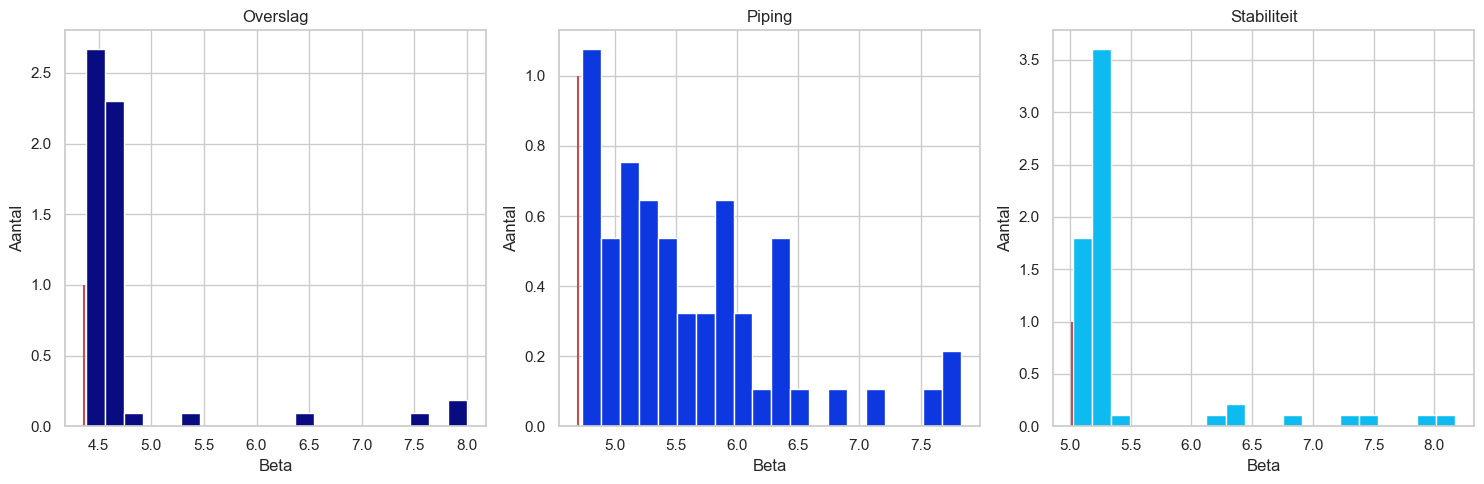

In [ ]:
target_betas_optimal = list(target_beta_grid_all)[min_idx]
N_values_optimal = [p_max/beta_to_pf(val) for val in target_betas_optimal]
print(N_values_optimal)

cost, pf, measures = calculate_cost(*target_betas_optimal, measures_df_with_dsn)

#plot the distribution of beta for each mechanism
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(measures['Overflow_dsn'], bins=20, color=colors[0], density=True)
ax[0].vlines(target_betas_optimal[0], 0, 1, color='r', label='Eis')
ax[0].set_title('Overslag')
ax[0].set_xlabel('Beta')

ax[0].set_ylabel('Aantal')
ax[1].hist(measures['Piping_dsn'], bins=20, color=colors[1],density=True)
ax[1].vlines(target_betas_optimal[1], 0, 1, color='r', label='Eis')
ax[1].set_title('Piping')
ax[1].set_xlabel('Beta')
ax[1].set_ylabel('Aantal')
ax[2].hist(measures['StabilityInner_dsn'], bins=20, color=colors[2], density=True)
ax[2].vlines(target_betas_optimal[2], 0, 1, color='r', label='Eis')
ax[2].set_title('Stabiliteit')
ax[2].set_xlabel('Beta')
ax[2].set_ylabel('Aantal')
plt.tight_layout()


In [ ]:
p_max/beta_to_pf(measures['Overflow_dsn'])

array([2.21796622e+01, 2.84926921e+01, 1.84816547e+01, 2.36529662e+01,
       9.08273196e+00, 3.81908827e+01, 1.38895330e+01, 2.19152813e+01,
       1.87881394e+01, 1.24256409e+01, 1.40663732e+01, 2.39518564e+01,
       1.55807511e+01, 2.72238817e+01, 1.17960879e+01, 1.07736661e+01,
       1.50878163e+01, 3.15540427e+09, 2.31322426e+01, 3.81660018e+01,
       8.62485351e+00, 1.33665495e+01, 8.35883774e+10, 8.35883774e+10,
       1.52949952e+01, 1.86696382e+01, 2.64821779e+01, 3.43163602e+01,
       3.88437458e+01, 1.81918719e+01, 2.00140255e+01, 1.48091644e+01,
       2.59896988e+01, 3.65368050e+01, 1.48022094e+01, 1.43596100e+01,
       3.58484015e+01, 3.10542508e+01, 1.70336130e+01, 3.10278494e+01,
       1.29686316e+01, 1.96960345e+01, 3.83655227e+01, 3.12395475e+01,
       2.02729134e+01, 1.06957780e+01, 3.04876919e+01, 4.96982190e+01,
       3.79984957e+01, 2.02022547e+01, 1.63943771e+01, 1.15751723e+01,
       3.05813585e+01, 1.73096313e+01, 1.83738781e+01, 1.71548155e+01,
      

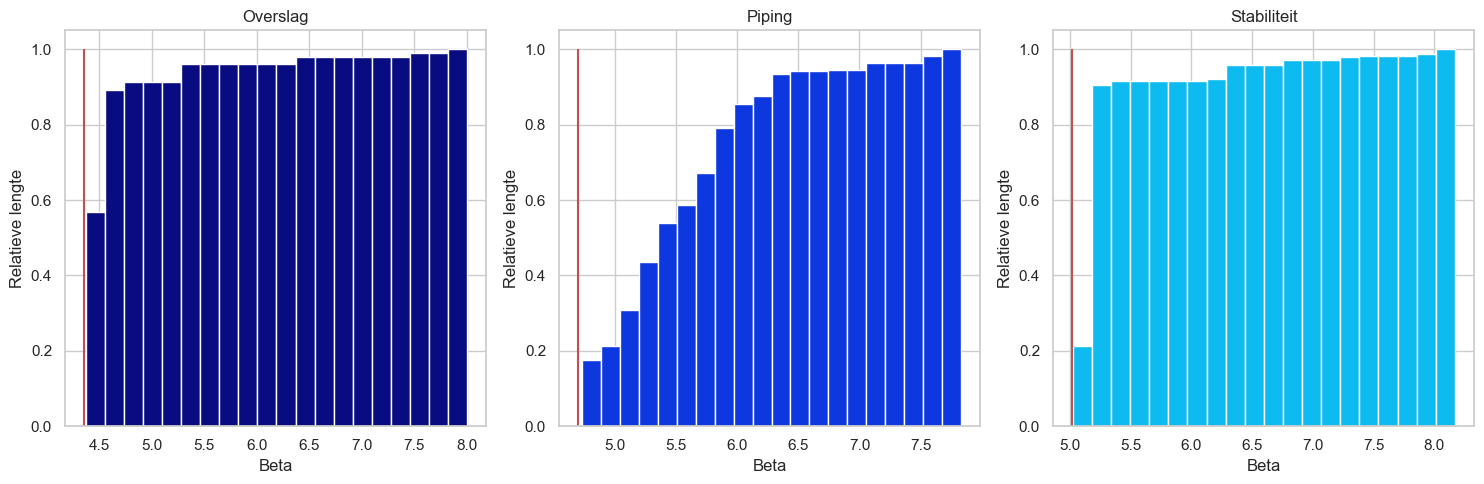

In [ ]:
#plot the cdf for each mechanism of the beta values. Weighted by the section length
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(measures['Overflow_dsn'], bins=20, color=colors[0], density=True, cumulative=True, weights=measures['section_length'])
ax[0].vlines(target_betas_optimal[0], 0, 1, color='r', label='Eis')
ax[0].set_title('Overslag')
ax[0].set_xlabel('Beta')
ax[0].set_ylabel('Relatieve lengte')


ax[1].hist(measures['Piping_dsn'], bins=20, color=colors[1],density=True, cumulative=True, weights=measures['section_length'])
ax[1].vlines(target_betas_optimal[1], 0, 1, color='r', label='Eis')
ax[1].set_title('Piping')
ax[1].set_xlabel('Beta')
ax[1].set_ylabel('Relatieve lengte')

ax[2].hist(measures['StabilityInner_dsn'], bins=20, color=colors[2], density=True, cumulative=True, weights=measures['section_length'])
ax[2].vlines(target_betas_optimal[2], 0, 1, color='r', label='Eis')
ax[2].set_title('Stabiliteit')
ax[2].set_xlabel('Beta')
ax[2].set_ylabel('Relatieve lengte')
plt.tight_layout()


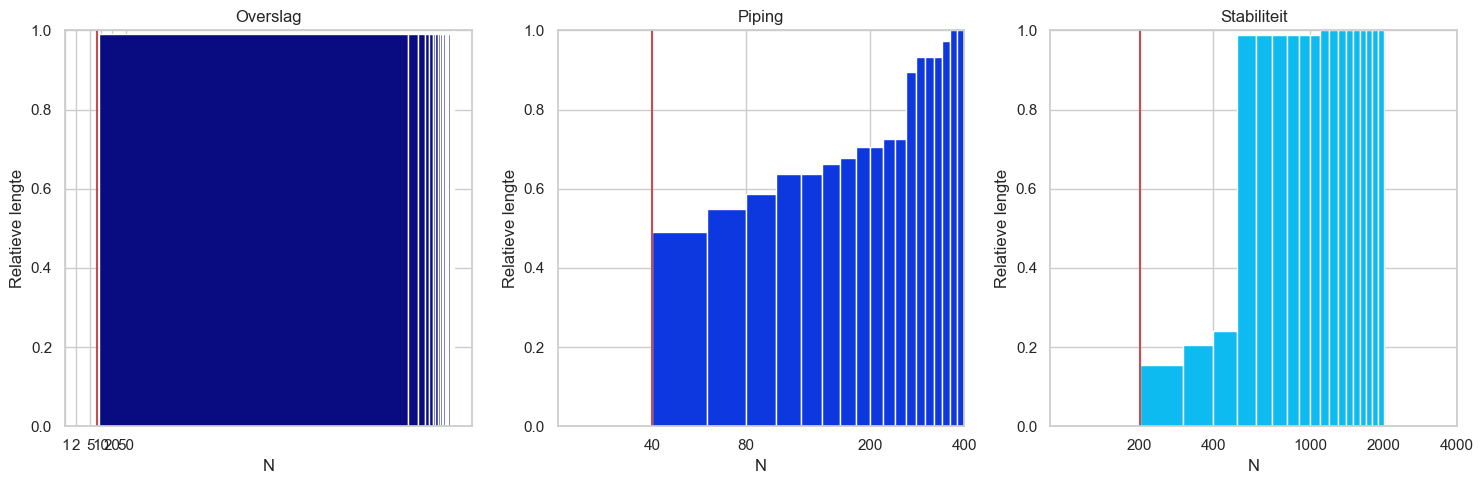

In [ ]:
#plot the cdf for each mechanism of the N-values. Weighted by the section length
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(p_max/beta_to_pf(measures['Overflow_dsn']), bins=20, color=colors[0], density=True, cumulative=True, weights=measures['section_length'])
ax[0].vlines(N_values_optimal[0], 0, 1, color='r', label='Eis')
ax[0].set_title('Overslag')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Relatieve lengte')
ax[0].set_xscale('log')
#add additional ticks
ax[0].set_xticks([1, 2, 5, 10, 20, 50])
ax[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())
#repeat for piping and stability. Maximize bins to the value of 10* N_values_optimal
ax[1].hist(p_max/beta_to_pf(measures['Piping_dsn']), bins=20, color=colors[1],density=True, cumulative=True, weights=measures['section_length'], range=(0, N_values_optimal[1]*10))
ax[1].vlines(N_values_optimal[1], 0, 1, color='r', label='Eis')
ax[1].set_title('Piping')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Relatieve lengte')
ax[1].set_xscale('log')
#add additional ticks
ax[1].set_xticks([N_values_optimal[1], N_values_optimal[1]*2, N_values_optimal[1]*5, N_values_optimal[1]*10, N_values_optimal[1]*20, N_values_optimal[1]*50])
ax[1].get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax[1].set_xlim(left=20, right = N_values_optimal[1]*10)

ax[2].hist(p_max/beta_to_pf(measures['StabilityInner_dsn']), bins=20, color=colors[2], density=True, cumulative=True, weights=measures['section_length'], range=(0, N_values_optimal[2]*10))
ax[2].vlines(N_values_optimal[2], 0, 1, color='r', label='Eis')
ax[2].set_title('Stabiliteit')
ax[2].set_xlabel('N')
ax[2].set_ylabel('Relatieve lengte')
ax[2].set_xscale('log')
#add additional ticks
ax[2].set_xticks([N_values_optimal[2], N_values_optimal[2]*2, N_values_optimal[2]*5, N_values_optimal[2]*10, N_values_optimal[2]*20])
ax[2].get_xaxis().set_major_formatter(plt.ScalarFormatter())

#max ylim 0 to 1 for all
for a in ax:
    a.set_ylim(top=1)
plt.tight_layout()


In [ ]:
#Theoretisch maximale kans o.b.v. eisen (volledig bijdragende lengte)
p_overslag = beta_to_pf(target_betas_optimal[0])
p_piping = 1-(1-beta_to_pf(target_betas_optimal[1])) ** (traject_length / b_piping)
p_stability = 1-(1-beta_to_pf(target_betas_optimal[2])) ** (traject_length / b_stability_inner)
p_traject = 1 - (1-p_overslag) * (1-p_piping) * (1-p_stability)
#print them all nicely
print(f'Theoretische kans overslag: {p_overslag:.2e}')
print(f'Theoretische kans piping: {p_piping:.2e}')
print(f'Theoretische kans stabiliteit: {p_stability:.2e}')
print(f'Theoretische kans traject: {p_traject:.2e}')

Theoretische kans overslag: 6.50e-06
Theoretische kans piping: 1.25e-04
Theoretische kans stabiliteit: 1.50e-04
Theoretische kans traject: 2.82e-04
